In [1]:
#check erosion/deposition inside meadows
#not using min/max hcan with interval of certain days
#instead: mean daily volume change while hcan is above or below certain value.
#--> run SyltRomo/eroded_vol_subtidal_nochange_sav_two_hcan.py first
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt

import math
import glob
import os.path
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files
import h5py
import os.path

from matplotlib import rcParams
rcParams['figure.dpi'] = 300

import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=1)

In [2]:
p5pat = 'work/gg0877/g260204/data/pickle_files'
study = 'srm02x3x'
figname = 'srm02x3x'
hcanlim1 = 0.1
hcanlim2 = 0.02
h5pypath= '/work/gg0877/g260204/data/pickle_files/'
run_labels=['no sg','stat sg (ref)','var sg (ref)','stat sg (int)','var sg (int)']
colors =  ['tab:blue','tab:orange','tab:green','orangered','darkgreen']#['tab:blue','midnightblue','gold','tab:orange','wheat','tan','peru','tab:green','lightgreen','darkseagreen','darkgreen','teal']
plotpat = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/' 
if not os.path.exists(plotpat+figname):
    os.makedirs(plotpat+figname)

In [3]:
runs=['srm020','srm026','srm024','srm035','srm036']
canopyref = 'srm024'
#sim x years x hcan x season
s_year=2010
e_year=2016
all_erovol = np.zeros((len(runs),e_year-s_year,3,2))
all_last =  np.zeros((len(runs),e_year-s_year,3,2))
heights = ['nocan','midcan','highcan']
for year in range(2010,2016):
    fname = h5pypath + study +'_'+str(year)+'_subtidal_' + str(hcanlim1) + '_' + str(hcanlim2) + '.hdf5'
    f = h5py.File(fname,'r')
    #min max canopy height -> use intertidal data for this, subtidal seagrass!!
    fnamehcan = h5pypath + study+'_'+str(year)+'_intertidal_' + str(hcanlim1) + '_' + str(hcanlim2) + '.hdf5'
    fhcan = h5py.File(fnamehcan,'r')
    #days hcan above threshold of 14 cm!
    hcan = np.array(fhcan[canopyref+'_'+str(year)+'_hcan_highcan'])
    imax = np.where(hcan>0.14)[0][[0,-1]]
    imin = np.where(hcan<0.06)[0][[0,-1]]
    #plt.plot(np.array(f[runs[2]+str(year)+'_hcan_highcan']))
    #plt.plot([imin-30,imin+30],np.array(f[runs[2]+str(year)+'_hcan_highcan'])[[imin-30,imin+30]],'x')
    #plt.plot([imax-30,imax+30],np.array(f[runs[2]+str(year)+'_hcan_highcan'])[[imax-30,imax+30]],'x')
    minmax = [imin,imax]
    print(year, 'min',imin,'max',imax)
    for run in range(0,len(runs)):
        for h in range(0,len(heights)):
            for s in range(0,2):
                #start
                varname = runs[run]+'_'+str(year)+'_'+heights[h]
                #print(varname)
                diff = -(f[varname][minmax[s][1]]-f[varname][minmax[s][0]])/(minmax[s][1]-minmax[s][0]) #invert because positive downward
                #print(diff)
                #write diff to array
                all_erovol[run,year-2010,h,s]=diff
                all_last[run,year-2010,h,s] = -f[varname][-1]
   
  
    #df = pd.DataFrame()
    #for title in f.keys():
    #    df[title]=np.array(h5py.File(h5pypath)[title])
    #f.close()

2010 min [ 42 156] max [207 350]
2011 min [ 22 148] max [211 338]
2012 min [ 17 155] max [222 343]
2013 min [ 29 156] max [215 339]
2014 min [ 20 147] max [200 348]
2015 min [ 15 159] max [221 344]


In [4]:
#mean over years w/ difference 
#sim x hcan x season
all_erovol = all_erovol-all_erovol[0,:,:,:]
mean_erovol = np.mean(all_erovol,1)
rmsd_erovol = np.sqrt(np.var(all_erovol,1))
mean_last = np.mean(all_last,1)
print('total volume change in areas:')
print('no seagrass: [low mid high all]',mean_last[0,:,1], np.sum(mean_last[0,:,1]))
print('static seagrass: [low mid high all]',mean_last[1,:,1],np.sum(mean_last[1,:,1]))
print('variable seagrass: [low mid high all]',mean_last[2,:,0],np.sum(mean_last[2,:,1]))

total volume change in areas:
no seagrass: [low mid high all] [-1.10213105e+07  7.51380323e+02  0.00000000e+00] -11020559.076811844
static seagrass: [low mid high all] [-1.10090694e+07  6.08980337e+02  0.00000000e+00] -11008460.376099266
variable seagrass: [low mid high all] [-1.10354568e+07  7.47178565e+02  0.00000000e+00] -11034709.618596384


/tmp/ipykernel_556841/4056339931.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


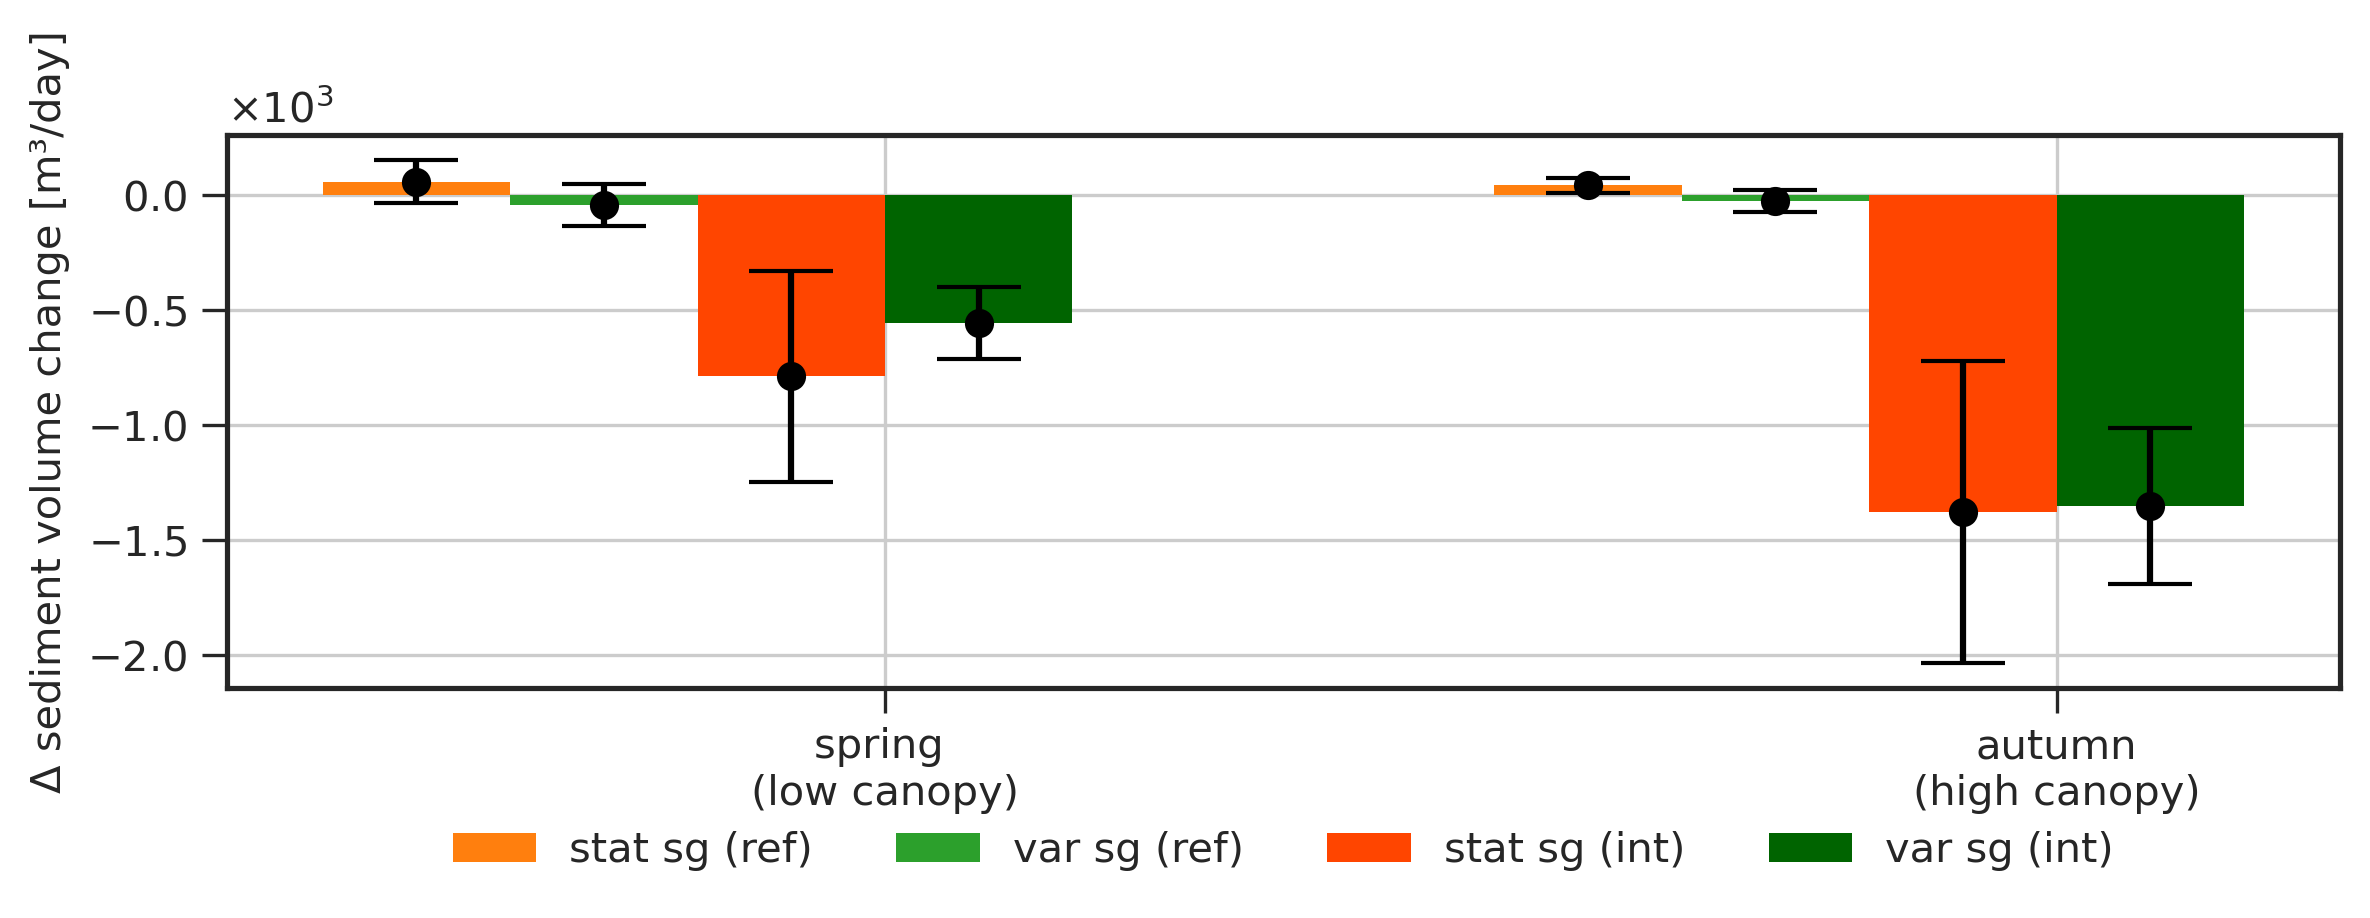

In [5]:
#all in one and pretty
#outside meadows

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(8)
ax.grid()
for run in range(1,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,0,:],width,label=run_labels[run],color = colors[run])
    ax.errorbar(x+offset,mean_erovol[run,0,:],yerr=rmsd_erovol[run,0,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.legend(loc='upper right', ncol=1)
#ax.set_ylim([-2.8e3,0.4e3])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)
plt.savefig(plotpat+ figname + '/daily_volume_change_subtidal_nocan_seasons_'+ heights[0]+'_diff.png')
    

/tmp/ipykernel_556841/1045638994.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


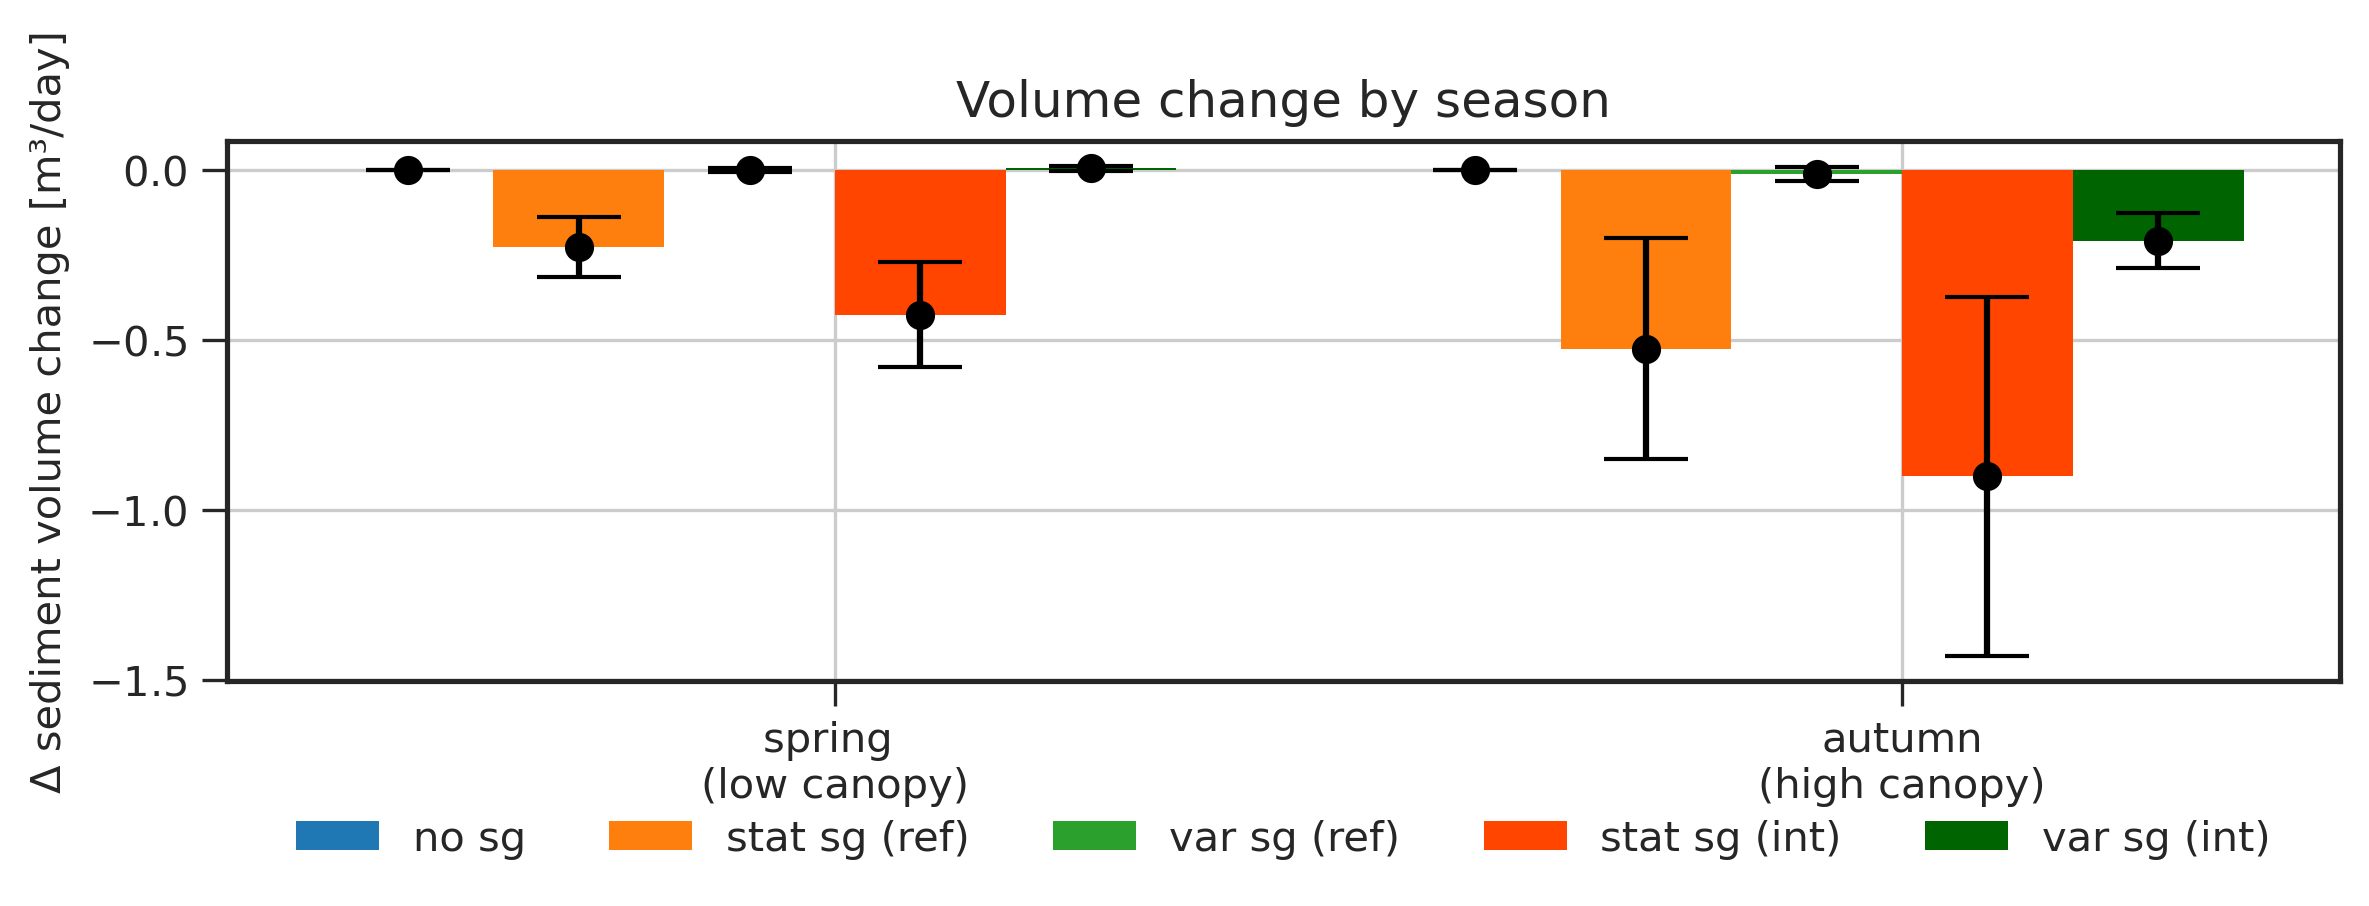

In [6]:
#all in one and pretty
#inside meadows, medium canopy height

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(8)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,1,:],width,label=run_labels[run],color=colors[run])    
    ax.errorbar(x+offset,mean_erovol[run,1,:],yerr=rmsd_erovol[run,1,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change [m³/day]')
ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.legend(loc='lower left', ncol=1)
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)
plt.savefig(plotpat+ figname + '/daily_volume_change_subtidal_nocan_seasons_'+ heights[1]+'_diff.png')
    

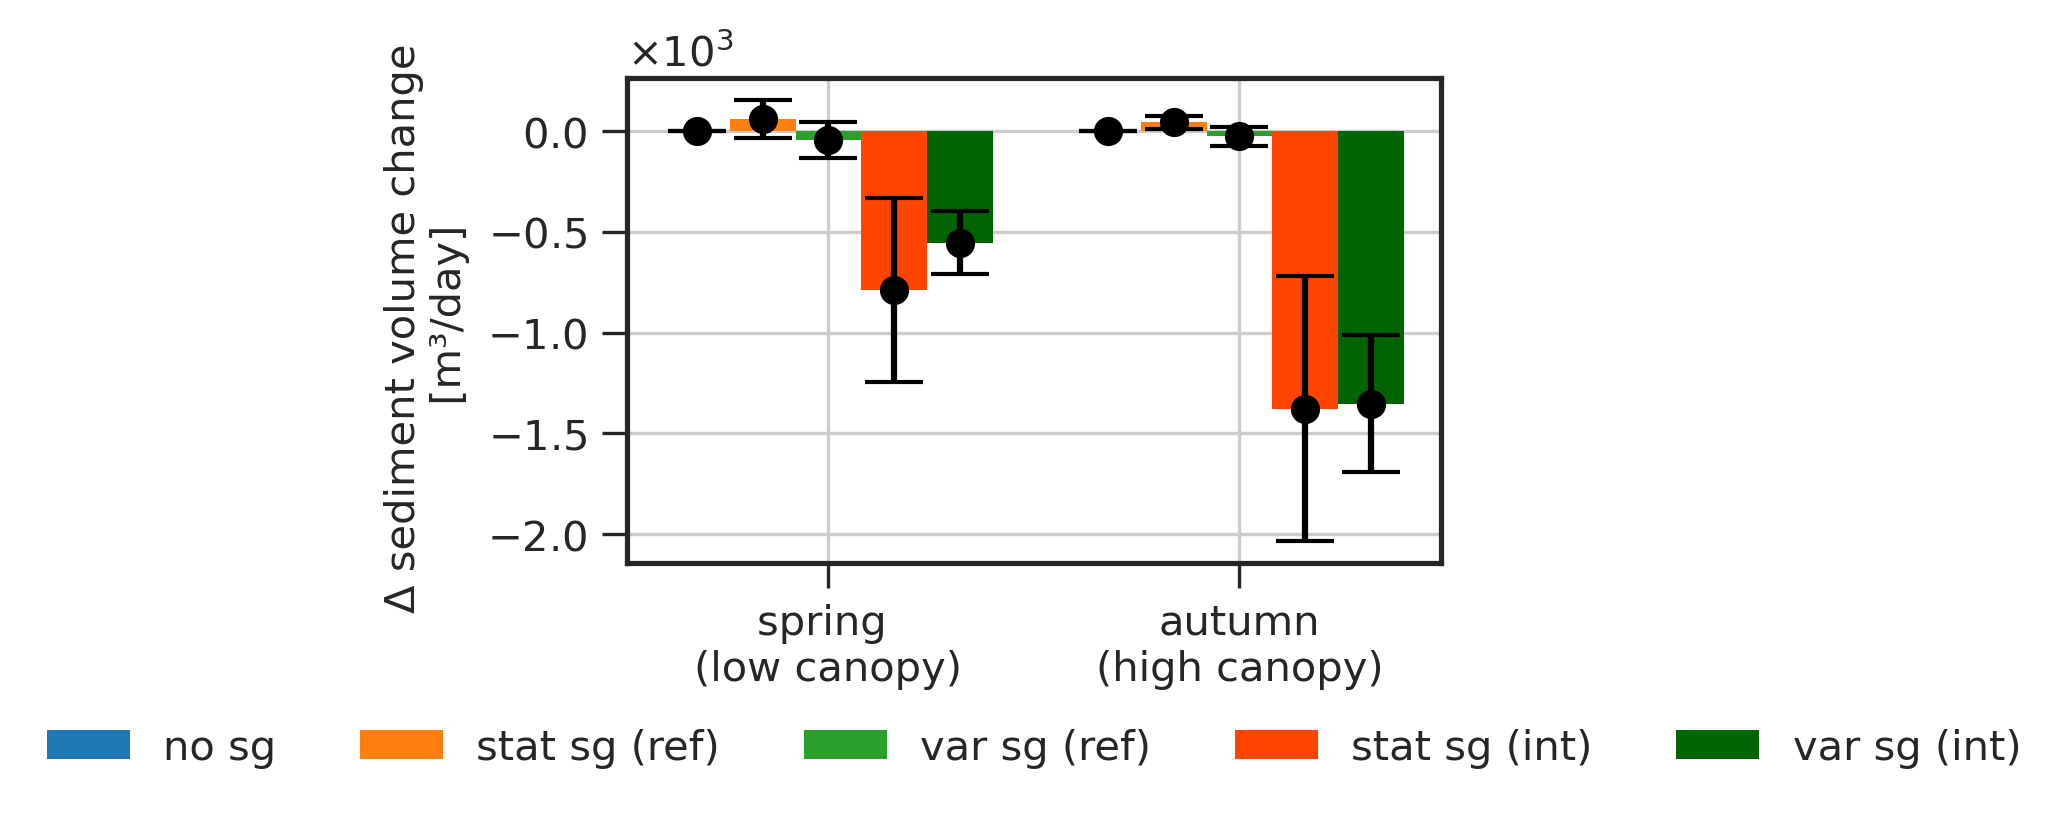

In [13]:
#all in one and pretty
#all subtidal

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3)
fig.set_figwidth(5)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,np.sum(mean_erovol,1)[run,:],width,label=run_labels[run],color=colors[run])
    ax.errorbar(x+offset,np.sum(mean_erovol,1)[run,:],yerr=np.sum(rmsd_erovol,1)[run,:],fmt='o',color='k',capsize = 7)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change \n [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
#ax.set_ylim([-2.8e3,0.4e3])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

#plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0 + box.width*0.2, box.y0 + box.height * 0.3,box.width*0.7, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fancybox=True, ncol=5)

plt.savefig(plotpat+ figname + '/daily_volume_change_subtidal_allsub_seasons_'+ heights[2]+'_all_diff.png')
 

/tmp/ipykernel_556841/6008975.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


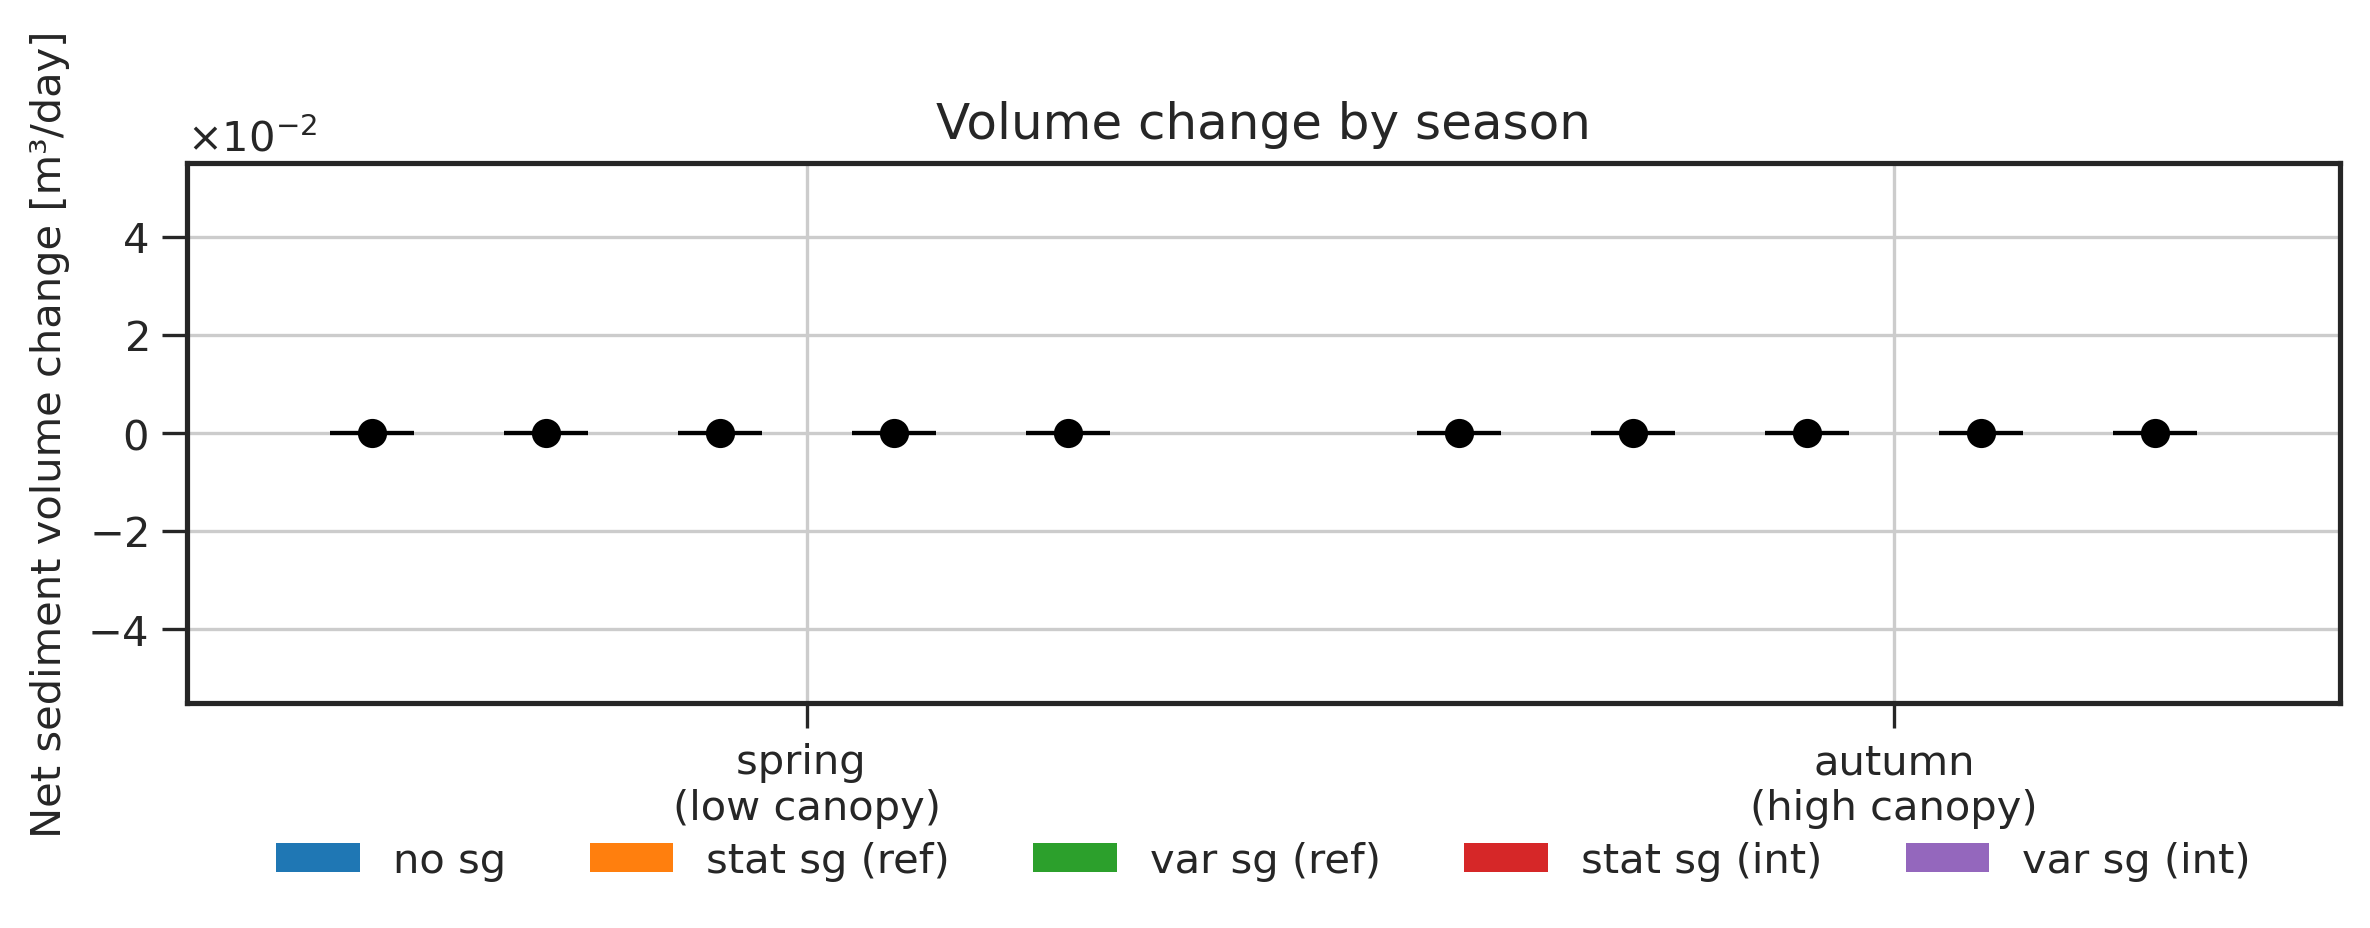

In [8]:
#all in one and pretty
#inside meadows, high canopy height

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(8)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,2,:],width,label=run_labels[run])
    ax.errorbar(x+offset,mean_erovol[run,2,:],yerr=rmsd_erovol[run,2,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Net sediment volume change [m³/day]')
ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.legend(loc='lower right', ncol=1)
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')
plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)

plt.savefig(plotpat+ figname + '/daily_volume_change_subtidal_nocan_seasons_'+ heights[2]+'.png')
    

In [9]:
#statistics spring:
print('outside meadows')
print('no seagrass total sed volume chage:',mean_erovol[0,0,0])
print('static seagrass total sed volume change:',mean_erovol[1,0,0])
print('variable seagrass total sed volume change:',mean_erovol[2,0,0])
print('perc. change static seagrass:', (mean_erovol[1,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])
print('perc. change variable seagrass:', (mean_erovol[2,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])

print('inside meadows (mid canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,0])
print('static seagrass total sed volume change:',mean_erovol[1,1,0])
print('variable seagrass total sed volume change:',mean_erovol[2,1,0])
print('perc. change static seagrass:',(mean_erovol[1,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])
print('perc. change variable seagrass:', (mean_erovol[2,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])

print('inside meadows (high canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,2,0])
print('static seagrass total sed volume change:',mean_erovol[1,2,0])
print('variable seagrass total sed volume change:',mean_erovol[2,2,0])
print('perc. change static seagrass:', (mean_erovol[1,2,0]-mean_erovol[0,2,0])/mean_erovol[0,2,0])
print('perc. change variable seagrass:', (mean_erovol[2,2,0]-mean_erovol[0,2,0])/mean_erovol[0,2,0])

print('inside meadows (total)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,0]+mean_erovol[0,2,0])
print('static seagrass total sed volume change:',mean_erovol[1,1,0]+mean_erovol[1,2,0])
print('variable seagrass total sed volume change:',mean_erovol[2,1,0]+mean_erovol[2,2,0])
print('perc. change static seagrass:', (mean_erovol[1,1,0]+mean_erovol[1,2,0] -(mean_erovol[0,1,0]+mean_erovol[0,2,0]))/ mean_erovol[0,1,0]+mean_erovol[0,2,0])
print('perc. change variable seagrass:', (mean_erovol[2,1,0]+mean_erovol[2,2,0] -(mean_erovol[0,1,0]+mean_erovol[0,2,0]))/ mean_erovol[0,1,0]+mean_erovol[0,2,0])

outside meadows
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 60.28398709310144
variable seagrass total sed volume change: -43.83566839663399
perc. change static seagrass: inf
perc. change variable seagrass: -inf
inside meadows (mid canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: -0.22771079017490736
variable seagrass total sed volume change: -0.0004283296008184741
perc. change static seagrass: -inf
perc. change variable seagrass: -inf
inside meadows (high canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 0.0
variable seagrass total sed volume change: 0.0
perc. change static seagrass: nan
perc. change variable seagrass: nan
inside meadows (total)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: -0.22771079017490736
variable seagrass total sed volume change: -0.0004283296008184741
perc. change static seagrass: -inf
perc. change 

/tmp/ipykernel_556841/1341633821.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])
/tmp/ipykernel_556841/1341633821.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])
/tmp/ipykernel_556841/1341633821.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:',(mean_erovol[1,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])
/tmp/ipykernel_556841/1341633821.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])
/tmp/ipykernel_556841/1341633821.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,2,0]-mean_erovol[0,2,0])/mean_erovo

In [10]:
#statistics autumn:
print('outside meadows')
print('no seagrass total sed volume chage:',mean_erovol[0,0,1])
print('static seagrass total sed volume change:',mean_erovol[1,0,1])
print('variable seagrass total sed volume change:',mean_erovol[2,0,1])
print('perc. change static seagrass:', (mean_erovol[1,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])
print('perc. change variable seagrass:', (mean_erovol[2,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])

print('inside meadows (mid canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,1])
print('static seagrass total sed volume change:',mean_erovol[1,1,1])
print('variable seagrass total sed volume change:',mean_erovol[2,1,1])
print('perc. change static seagrass:',(mean_erovol[1,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])
print('perc. change variable seagrass:', (mean_erovol[2,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])

print('inside meadows (high canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,2,1])
print('static seagrass total sed volume change:',mean_erovol[1,2,1])
print('variable seagrass total sed volume change:',mean_erovol[2,2,1])
print('perc. change static seagrass:', (mean_erovol[1,2,1]-mean_erovol[0,2,1])/mean_erovol[0,2,1])
print('perc. change variable seagrass:', (mean_erovol[2,2,1]-mean_erovol[0,2,1])/mean_erovol[0,2,1])

print('inside meadows (total)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,1]+mean_erovol[0,2,1])
print('static seagrass total sed volume change:',mean_erovol[1,1,1]+mean_erovol[1,2,1])
print('variable seagrass total sed volume change:',mean_erovol[2,1,1]+mean_erovol[2,2,1])
print('perc. change static seagrass:', (mean_erovol[1,1,1]+mean_erovol[1,2,1] -(mean_erovol[0,1,1]+mean_erovol[0,2,1]))/ mean_erovol[0,1,0]+mean_erovol[0,2,1])
print('perc. change variable seagrass:', (mean_erovol[2,1,1]+mean_erovol[2,2,1] -(mean_erovol[0,1,1]+mean_erovol[0,2,1]))/ mean_erovol[0,1,1]+mean_erovol[0,2,1])

outside meadows
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 43.33852159325276
variable seagrass total sed volume change: -24.88348235905384
perc. change static seagrass: inf
perc. change variable seagrass: -inf
inside meadows (mid canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: -0.5268106728805311
variable seagrass total sed volume change: -0.013209977718812863
perc. change static seagrass: -inf
perc. change variable seagrass: -inf
inside meadows (high canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 0.0
variable seagrass total sed volume change: 0.0
perc. change static seagrass: nan
perc. change variable seagrass: nan
inside meadows (total)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: -0.5268106728805311
variable seagrass total sed volume change: -0.013209977718812863
perc. change static seagrass: -inf
perc. change vari

/tmp/ipykernel_556841/3198422608.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])
/tmp/ipykernel_556841/3198422608.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])
/tmp/ipykernel_556841/3198422608.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:',(mean_erovol[1,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])
/tmp/ipykernel_556841/3198422608.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])
/tmp/ipykernel_556841/3198422608.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,2,1]-mean_erovol[0,2,1])/mean_erovo